In [3]:
import csv
import pandas as pd
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/pb196/data.csv')

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6,10,22,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.head()

,raw_row_number,date,time,location,lat,lng,beat,subject_age,subject_race,subject_sex,officer_assignment,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_basis,reason_for_stop,use_of_force_description,raw_subject_sdrace,raw_subject_resultofencounter,raw_subject_searchconducted,raw_subject_typeofsearch,raw_subject_resultofsearch
0,17213,NaN,01:33:00,E. 28th St. & Park BLVD,37.803084,-122.237247,NaN,NaN,asian/pacific islander,female,NaN,vehicular,False,True,False,citation,NaN,NaN,NaN,False,NaN,Traffic Violation,NaN,A,"Citation,",No,NaN,NaN
1,17214,NaN,14:48:00,1759 SEMINARY AV,37.767568,-122.196820,NaN,NaN,black,male,NaN,NaN,False,False,False,NaN,False,False,False,True,other,Probation/Parole,NaN,B,"FI Report,",Yes,"Prob./Parole,",NaN
2,1,2013-04-01,00:00:00,31st St And Mlk Jr Way,37.820599,-122.270734,NaN,NaN,white,male,NaN,vehicular,False,False,True,warning,False,False,False,True,other,Traffic Violation,NaN,W,"Warning,",Yes,"Prob./Parole,",NaN
3,2,2013-04-01,00:01:00,3000 Block Of San Pablo Ave,37.821246,-122.276488,NaN,NaN,black,male,NaN,vehicular,False,False,False,NaN,NaN,NaN,NaN,False,NaN,Traffic Violation,NaN,B,"FI Report,",No,NaN,NaN
4,19,2013-04-01,10:41:00,12th St/Broadway,37.802937,-122.271738,NaN,NaN,hispanic,female,NaN,NaN,False,True,False,citation,NaN,NaN,NaN,False,NaN,Probable Cause,NaN,H,"Citation,",No,NaN,NaN


In [6]:
set(data['subject_race'])

{'asian/pacific islander', 'black', 'hispanic', 'other', 'white'}

In [7]:
data.columns

Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'beat',
       'subject_age', 'subject_race', 'subject_sex', 'officer_assignment',
       'type', 'arrest_made', 'citation_issued', 'warning_issued', 'outcome',
       'contraband_found', 'contraband_drugs', 'contraband_weapons',
       'search_conducted', 'search_basis', 'reason_for_stop',
       'use_of_force_description', 'raw_subject_sdrace',
       'raw_subject_resultofencounter', 'raw_subject_searchconducted',
       'raw_subject_typeofsearch', 'raw_subject_resultofsearch'],
      dtype='object')

In [8]:
data['action'] = data['citation_issued'] | data['arrest_made']

In [9]:
inputs = ['subject_race', 'subject_sex', 'lat', 'lng', 'subject_age', 'reason_for_stop']
label = ['action']

In [10]:
data['subject_age'].median()

29.0

In [11]:
data['subject_age'] = data['subject_age'].fillna(data['subject_age'].median())

In [12]:
set(data['reason_for_stop'])

{'Consensual Encounter',
 'Consensual Encounter|Consensual Encounter|Consensual Encounter|Traffic Violation',
 'Consensual Encounter|Consensual Encounter|Probable Cause',
 'Consensual Encounter|Consensual Encounter|Probable Cause|Reasonable Suspicion',
 'Consensual Encounter|Consensual Encounter|Reasonable Suspicion|Reasonable Suspicion',
 'Consensual Encounter|Consensual Encounter|Traffic Violation',
 'Consensual Encounter|Probable Cause',
 'Consensual Encounter|Probable Cause|Consensual Encounter',
 'Consensual Encounter|Probable Cause|Consensual Encounter|Probable Cause',
 'Consensual Encounter|Probable Cause|Probable Cause|Probable Cause|Probable Cause',
 'Consensual Encounter|Probable Cause|Probation/Parole',
 'Consensual Encounter|Probation/Parole',
 'Consensual Encounter|Reasonable Suspicion',
 'Consensual Encounter|Reasonable Suspicion|Reasonable Suspicion',
 'Consensual Encounter|Traffic Violation',
 'Consensual Encounter|Traffic Violation|Traffic Violation',
 'Other-Consensua

In [13]:
data[inputs + label].head()

,subject_race,subject_sex,lat,lng,subject_age,reason_for_stop,action
0,asian/pacific islander,female,37.803084,-122.237247,29.0,Traffic Violation,True
1,black,male,37.767568,-122.196820,29.0,Probation/Parole,False
2,white,male,37.820599,-122.270734,29.0,Traffic Violation,False
3,black,male,37.821246,-122.276488,29.0,Traffic Violation,False
4,hispanic,female,37.802937,-122.271738,29.0,Probable Cause,True


In [14]:
races = list(set(data['subject_race']))
sexes = list(set(data['subject_sex']))
reasons = list(set(data['reason_for_stop']))

In [15]:
data['clean_lng'] = data['lng'] - data['lng'].mean() 
data['clean_lat'] = data['lat'] - data['lat'].mean()
data['clean_age'] = data['subject_age'] - data['subject_age'].mean()

In [16]:
data['race'] = data.apply(lambda row: races.index(row['subject_race']), axis=1)
data['sex']= data.apply(lambda row: sexes.index(row['subject_sex']), axis=1)
data['reason']= data.apply(lambda row: reasons.index(row['reason_for_stop']), axis=1).astype(int)

In [17]:
inputs = ['race', 'sex', 'clean_lat', 'clean_lng', 'clean_age']#, 'reason']
label = 'action'

## XGBoost Model

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [19]:
data_clean = data[inputs + [label]].dropna(axis = 0, subset= inputs + [label])
X = data_clean[inputs]
y = data_clean[label]
X.shape, y.shape

((133293, 5), (133293,))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [23]:
xgbr = xgb.XGBClassifier(learning_rate = 0.15, booster = "gbtree", max_depth = 15, eta = 0.5, n_estimators = 150) 
xgbr.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [24]:
print(np.mean(xgbr.predict(X_train) == y_train))
print(np.mean(xgbr.predict(X_test) == y_test))

0.7373523503080116
0.5834958739684921


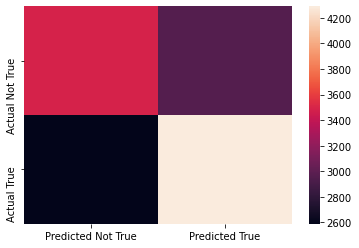

In [25]:
import seaborn
import sklearn
from sklearn.metrics import confusion_matrix

seaborn.heatmap(confusion_matrix(y_test, xgbr.predict(X_test)),
                yticklabels=['Actual Not True', 'Actual True'], xticklabels=['Predicted Not True', 'Predicted True'])